# Download SWOT swaths that intersect with a specific region from the AVISO THREDDS Server

### Here we'll use some scripts to download SWOT data in a specific region from AVISO THREDDS. 
##### Downloading from THREDDS using HTTP GET requests is much faster than sftp (see example notebook 002...) and allows for parallel downloads.

- This notebook uses scripts from <code>src/THREDDS_download_swaths.py</code>. 
- Note that we are using the <code>reqiests.get()</code> method to directly pull swaths from the [AVISO THREDDS](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/catalog.html) data catalog using an <code>HTTP GET</code> request, and as such we need to download each swath in it's entirety before subsetting. This is a little inefficient but at least it's faster than my previous sftp method...
- You can just use my login information, provided here, to access AVISO
- NOTE: As an example, I wrote this script to save L3 SWOT swaths to a folder in the base directory named "<code>SWOT_L3</code>", which has been added to the <code>.gitignore</code> file. You should change the save path to wherever is most convienent for you. If you save your files to a different directory on the main path remember to add the save directory to <code>.gitignore</code> to avoid problems with large files.


### Before you begin:
- Make sure you've downloaded the orbit shape files to tell the script where the specific tracks are. You need two shape files for the open ocean's calval and science phases, <code>sph_calval_nadir.zip</code> and  <code>sph_science_nadir.zip</code>, which you can download the here [here](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit/science-orbit.html). 

In [14]:
"""
Download SWOT swaths in a specific bounding box.

Dependencies:
numpy
xml
tqdm
geopandas
shapely
matplotlib
cartopy
xarray

Author: Tatsu Monkman
Date: 2025-06-24
"""
import os
import time
import geopandas as gpd
import shapely.geometry as geometry
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Add the path to the Tatsu's swot download library
import sys
sys.path.append('../src/')
import THREDDS_download_swaths


# Specify AVISO login info to access the AVISO THREDDS Server

In [6]:
# Define sftp connection parameters. Here I am just using my own login info. 
# Feel free to change, but you should probable leave the "port" the same
ssh_kwargs = {
              "username":"tdmonkman@uchicago.edu",
              "password":"2prSvl"
            }

In [7]:
os.getcwd()

'/scratch/projects/shaferlab/tatsu/NYU_SWOT_project/SWOT-data-analysis/examples'

## Find swaths that intersect the lat-lon boundaries you are interested in

In [18]:
# Define bounding domain, here I'm downloading some swaths 
# over the Kuroshio east of Japan.

# North Pacific
sw_corner = [-153.5, 35.3]
ne_corner = [-147.5, 42.3]


# NOTE: I am specifically recording the Northern and Southern edges
# of the bounding box here for later use when I subset the data.
# I find it helpful to add them to a new list to keep everything 
# organized.
kuroshio_lat_lims = [sw_corner[1],ne_corner[1]]

# Load the shapefile
gdf_karin = gpd.read_file("../../orbit_data/sph_calval_swath.zip")
gdf_karin = gpd.read_file("../../orbit_data/sph_science_swath.zip")

bbox = geometry.box(sw_corner[0], sw_corner[1], ne_corner[0], ne_corner[1])
overlapping_segments = gdf_karin[gdf_karin.intersects(bbox)]

pass_IDs_list = [str(pass_id).zfill(3) for pass_id in overlapping_segments.ID_PASS]

/ext3/miniforge3/envs/swot_python12/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /vsizip/../../orbit_data/sph_calval_swath.zip/swot_calval_orbit_june2015-v2_swath.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


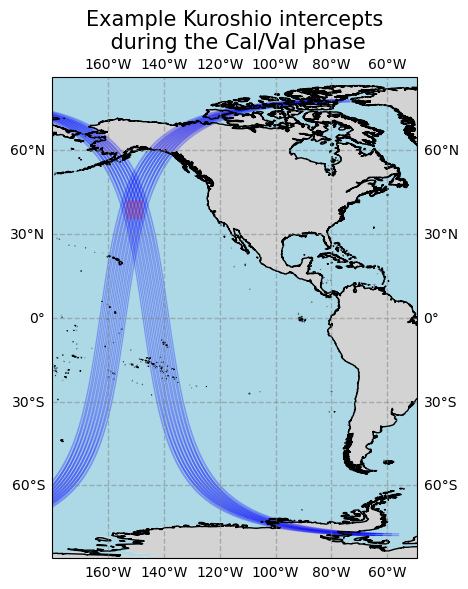

In [19]:
# Set up plot
subplot_kw = {'projection': ccrs.PlateCarree()}

fig, axs = plt.subplots(1,1,figsize=(50,6),subplot_kw=subplot_kw)

axs.set_title("Example Kuroshio intercepts\n during the Cal/Val phase",fontsize=15)

axs.add_feature(cfeature.COASTLINE.with_scale('10m'))
axs.add_feature(cfeature.LAND, edgecolor='none', facecolor='lightgray')
axs.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
# Plot the shapefile data
#gdf.plot(ax=ax, transform=ccrs.PlateCarree())
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')

overlapping_segments.plot(ax=axs,alpha=0.3,color="b")

b = gpd.GeoSeries(bbox)
b.plot(ax=axs,color="r",alpha=0.2)


#axs.set_extent([-65, -10, 55, 90], crs=ccrs.PlateCarree())

plt.tight_layout()

plt.show()
plt.close()

In [20]:
pass_IDs_list

['013',
 '026',
 '041',
 '054',
 '069',
 '097',
 '276',
 '291',
 '304',
 '319',
 '332',
 '347',
 '360',
 '375',
 '554',
 '582']

## Specify the cycles you want to download

Key points:
- SWOT data is organized by orbit "cycle" on AVISO. Each numbered cycle corresponds to one full traversal of the individual swaths that make up a complete orbital cycle. Cycles numbered 474-578 correspond to 1-day repeat orbits made during the Cal/Val phase, while cycles numbered 001-016+ correspond to orbits made during the science phase. Note you need to keep the leading zeros on the labels for the low-numbered cycles since the filenames use standardized lengths.
- Each cycle is subdivided into individual "passes" which correspond to one North-South or South-North path of the SWOT satellite as it moves along its orbit. Each pass is given an identification number, which can be used to find specific swaths you are interested in. The orbital shape files in  <code>../orbit_data/</code> specify the pass identification number using the variable "PASS_ID".
- Pass IDs correspond to the order in which each pass occured during each cycle. For example, "Pass 1" in the science phase is the first pass of a given science cycle, and "Pass 1" in the Cal/Val phase is the first pass in a given Cal/Val cycle.
- Every "pass" is repeated for every "cycle". For example, if you want to find all the SWOT data in the California region you would first look at which passes travel through the region, then download those specific passes for all of the cycles you are interested in.

In [21]:
"""
Below is some code to specify the passes and cycles to download.

Here we are downloading passes in the Kuroshio from all of the Cal/Val cycles,
i.e. cycles 474-578, and the first Science cycle, cycle 001.

"""

# EXAMPLE: Cycles 001 - 016 are for the 21-day science phase
# cycles = [str(c_num).zfill(3) for c_num in range(1,17)]

# EXAMPLE: Cycles 474 - 578 are from the 1-day repeat Cal/Val phase
# cycles = [str(c_num).zfill(3) for c_num in range(474,578)]

# Here I'm just pulling the first 10 cycles from the 1-day repeat Cal/Val phase 
# and the first cycle of the science phase.
cycles = ["008","015"] 


In [22]:
cycles

['008', '015']

## Specify the path to the orbit shapefile

You need to specify the path to the orbit shapfiles so my scripts can figure out which swaths you want

In [23]:
orbit_file_path = "../../orbit_data"

## Specify the path to the data on the AVISO THREDDS server

Next we want to specify where to look for the data on the AVISO ftp server. Here are some example paths for a) the L2 PID0 Unsmoothed data and b) the L3 v2.0.1 Unsmoothed data:

```python
    # Paths for L2 PID0 Unsmoothed data
    remote_path="https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PID0/Unsmoothed"
    # Paths for L3 v2.01 Unsmoothed data
    remote_path="https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed"    
```

You can poke around on the THREDDS server for the specific data release you want here:

```unix
https://tds-odatis.aviso.altimetry.fr/thredds/catalog/catalog.html
```

I'm looking for version 2.0.1 release of the SWOT L3 Unsmoothed data, so I've specified the path to this specific release on the THREDDS server:

In [24]:
orbit_file_path

'../../orbit_data'

In [25]:
import glob
glob.glob(f"{orbit_file_path}/*")

['../../orbit_data/sph_science_nadir.zip',
 '../../orbit_data/sph_calval_nadir.zip',
 '../../orbit_data/sph_calval_swath.zip',
 '../../orbit_data/sph_science_swath.zip',
 '../../orbit_data/mss_sio_32.1_WGS84.nc']

In [26]:
import geopandas as gpd 
gdf_karin = gpd.read_file(f"{orbit_file_path}/sph_science_nadir.zip")

In [27]:
remote_path="https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed"


product = remote_path.split("/")[-1]
product

'Unsmoothed'

## Specify the remote path to access the data and the local_path you want to save it to on your machine
I'm saving the data in this example to my scratch directory on Greene.

In [32]:
save_path = "/scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific"

# Download the data

The script below downloads the data for the given passes and cycles you are interested in. Note I've instructed the script to generate an extra log file (the <code>skipped_swaths.txt</code> file) to record when there's a problem and the script fails to download the data.

Good luck!

In [33]:
pass_IDs_calval = ['002', '013', '015', '017', '026', '028', '002', '004', '017', '019']
pass_IDs_science = ['011', '013', '015', '024', '026', '028', '039', '041', '043', '052', 
                    '054', '056', '067', '069', '071', '080', '082', '084', '095', '097', 
                    '099', '108', '110', '112', '123', '125', '127', '134', '136', '138', 
                    '151', '153', '155', '162', '164', '166', '179', '181', '190', '192', 
                    '194', '205', '207', '209', '218', '220', '222', '233', '235', '237', 
                    '246', '248', '250', '261', '263', '265', '274', '276', '278', '289', 
                    '291', '293', '302', '304', '306', '317', '319', '321', '330', '332', 
                    '334', '345', '347', '349', '358', '360', '362', '373', '375', '377', 
                    '386', '388', '390', '401', '403', '405', '412', '414', '416', '429', 
                    '431', '433', '440', '442', '444', '457', '459', '461', '468', '470', 
                    '472', '483', '485', '487', '496', '498', '500', '511', '513', '515', 
                    '524', '526', '528', '539', '541', '543', '552', '554', '556', '567', 
                    '569', '571', '580', '582', '584', '002', '017', '028', '030', '043', 
                    '045', '056', '058', '071', '073', '084', '086', '099', '101', '112', 
                    '114', '127', '129', '140', '142', '155', '157', '168', '170', '183', 
                    '185', '196', '198', '211', '213', '224', '239', '241', '252', '267', 
                    '269', '278', '280', '295', '306', '308', '323', '334', '336', '349', 
                    '351', '362', '364', '377', '379', '390', '392', '405', '407', '418', 
                    '420', '433', '435', '446', '448', '461', '463', '474', '476', '489', 
                    '491', '502', '504', '517', '519', '530', '545', '547', '558', '573', '584', ]


In [36]:
save_path_test = "/scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008"
os.makedirs(save_path, exist_ok=True)

PermissionError: [Errno 13] Permission denied: '/scratch/SWOT_L3_v2_0_1'

In [35]:
from importlib import reload
THREDDS_download_swaths = reload(THREDDS_download_swaths)
#THREDDS_download_swaths.run_download(sw_corner, ne_corner, cycles, remote_path, save_path, orbit_file_path, ssh_kwargs)
THREDDS_download_swaths.run_download(pass_IDs, cycles, remote_path, save_path, ssh_kwargs, find_swaths=False)



product Unsmoothed
Fetching catalog for Unsmoothed cycle 008...
save_path /scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008
Failed to download https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed/cycle_008/SWOT_L3_LR_SSH_Unsmoothed_008_050_20231216T005013_20231216T014140_v2.0.1.nc: [Errno 13] Permission denied: '/scratch/SWOT_L3_v2_0_1'
save_path /scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008/cycle_008
Failed to download https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed/cycle_008/SWOT_L3_LR_SSH_Unsmoothed_008_126_20231218T180013_20231218T185140_v2.0.1.nc: [Errno 13] Permission denied: '/scratch/SWOT_L3_v2_0_1'
save_path /scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008/cycle_008/cycle_008
Failed to download https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_